# Exploratory analysis of location data
Simon Kamronn, sdka@dtu.dk <br/>
Technical University of Denmark <br/>

## Introduction
Analysis of spatio-temporal movement data can seem to be a privilegium of the Geographical Information Science(GISc) community and require the use of traditional Geographic Information System(GIS) tools (e.g. ArcGIS). Tools of which most are either expensive or difficult to learn to use efficiently and correctly. They can naturally add great value to the analysis but can also be an obstacle for outsiders and hamper the understanding of underlying algorithms applied to the data. Furthermore, relying on existing tools you may arrive at the wrong conclusion because the tools doesn't fit the question you ask.  

As mentioned in (Van der Spek, 2009) movement tracking through GPS was at that time identified as having great potential for analysing movement patterns in cities but they also foresaw difficulties in analysing the data with their relatively manual approach relying on visualizations. The possible scale of this type of study was seen in (Stopczynski, 2014) with a cohort of 1000 individuals in Copenhagen spanning multiple years. At this scale automation of analysis becomes a necessity fast. Because movement analysis is an important topic in GISc it has received a lot of attention in research and development over the past decade. Some even argues that Computational Movement Analysis(CMA) has reached a level in which all the *soft* problems are solved but many harder problems with more abstract inferences are still not addressed(Laube, 2015). The *hard* problems are of particular interest because it is here we move into the realm of cognition and begin to understand human behaviour. 

In the study my PhD project is part of we explore the ability of smartphones and apps (as personalized lifestyle devices) to motivate, monitor, and maintain physical activity in overweight individuals. Specifically the project address smartphone and wearable sensing as means to monitor physical activity, estimate energy expenditure, establish the domains in daily life (home, transportation, occupational and leisure) in which physical activity occur, as well as assist individuals in maintaining physical activity through biofeedback interfaces.

The project is carried out in collaboration with University of Copenhagen (KU Sund) and leverages an ongoing randomized clinical trial, GO-ACTIWE (Governing Obesity- Active Commuting to Improve Well-being and health in Everyday life), in which the health effects of physical activity in transportation and leisure-time domains of everyday life is evaluated. Participants in the GO-ACTIWE trial are randomized to one of four 6-month interventions consisting of 3 different exercise regimes and one control group. Participants undergo rigorous biomedical testing before and at 1, 3 and 6 months of the intervention and data on physical activity and energy expenditure will be acquired and participants will be monitored across multiple domains.

From the presentations of mainly Patrick Laube and Stefan van der Spek during the PhD course Human mobility, cognition and GISc, I was introduced to a broader scope of opportunities in analysing spatio-temporal data, specifically trajectories and the behavioural aspects. I have here chosen to analyse the data I have available without using a GIS toolbox in order to not confine myself within the traditions of GISc but still retain the possibility of drawing inspiration from the literature.

In the spirit of Quantified Self, the concept of quantifying yourself through tracking, I will analyse my movement data collected by my smartphone and stored by Google. That is, data that is available to anyone with a smartphone and any researcher with permission to access the data. I choose this perspective because my project concerns what we can infer from personal devices and from sharing this hopefully someone will find it useful. The approach is very ad hoc and progress in a natural way with each step building on the previous. 

## Setup
This is a Jupyter Notebook in which it is possible to both write text and evaluate code and such there will be rather long segments of code that is not necessary to read and understand. To every cell of code there is a comment to its purpose and if it produces an output that is commented as well so it should be sufficient to only read those but the code may explain in more detail. This first cell just imports the Python libraries we use. 

In [1]:
# Set up imports
import os
import base64
import pickle
import json
import oauth2client.client
from googleapiclient.discovery import build
from datetime import datetime, timedelta
import httplib2

import numpy as np
import pandas as pd
from sensible.stops import getstops_dbscan

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 8)

from time import time
from geopy.distance import distance
from geopy.geocoders import GoogleV3
import googlemaps

import folium
from folium.plugins import MarkerCluster
from folium.features import PolyLine, MultiPolyLine
from IPython.display import display

### Pull data from Google

Load Google API key for later use and credentials from JSON file. To run the code you need to acquire these yourself. 

In [2]:
with file('client_secrets.json') as f:
    d = json.load(f)
    api_key = d['geocoding_api_key']
    credentials_str = d['google_credentials']

The credentials are pickled in a CredentialsModel object from *oauth2client.client* so unpickling gives us this object directly

In [3]:
credentials = pickle.loads(base64.b64decode(credentials_str))

Because both authentication and refresh token are stored in the object we can easily authorize with Google's backend. The authorization tokens only last an hour but the refresh token last untill they are revoked. Connecting to the service we want to acquire data from is done through *googleapiclient.discovery.build*

In [4]:
http = httplib2.Http()
http = credentials.authorize(http)
service = build('fitness', 'v1', http=http)

It is quite difficult to find out what datasources that are available from the documentation. My guess is because it depends on the data collected by the user and any app can make a new datasource so keeping a record is impossible. To get the available datasources you can query them. In this case I only look at the *derived* sources that are a collection of data from multiple *raw* sources

In [5]:
dataSources = service.users().dataSources().list(userId="me").execute()

# Available derived data sources
our_sources =[]
for s in dataSources['dataSource']:
    s = s['dataStreamId']
    if s.startswith('derived') and not any([x in s for x in ['Nexus', 'samsung', 'Sony']]):
        our_sources.append(s)
        print(s)

derived:com.google.activity.segment:com.google.android.gms:activity_from_steps
derived:com.google.activity.segment:com.google.android.gms:merge_activity_segments
derived:com.google.activity.segment:com.google.android.gms:platform_activity_segments
derived:com.google.activity.segment:com.google.android.gms:session_activity_segment
derived:com.google.activity.segment:fi.polar.beat:session_activity_segment
derived:com.google.activity.segment:fi.polar.polarflow:session_activity_segment
derived:com.google.calories.bmr:com.google.android.gms:from_height&weight
derived:com.google.calories.bmr:com.google.android.gms:merged
derived:com.google.calories.expended:com.google.android.gms:default_calories_expended
derived:com.google.calories.expended:com.google.android.gms:from_activities
derived:com.google.calories.expended:com.google.android.gms:from_bmr
derived:com.google.calories.expended:com.google.android.gms:merge_calories_expended
derived:com.google.calories.expended:com.google.android.gms:pl

To query data we need to specify a start and end time in nanoseconds. The limit to how many samples we can get in one query seems to be 100.000 and depending on datasource that can span from months to many years. With location it is around 9 months for me but that also varies across people since the datasource is not sampled uniformly. 

In [6]:
num_days = 365  # Limited to 100000 samples so this is too long but the backend will truncate

# num_days days ago
dt = datetime.strptime(datetime.date(datetime.today() - timedelta(days=num_days)).strftime('%Y-%m-%d'), '%Y-%m-%d')
start_time_nsec = (dt - datetime(1970, 1, 1)).total_seconds() * 1e9
end_time_nsec = (datetime.today() - datetime(1970, 1, 1)).total_seconds() * 1e9

To make the query and formatting easy I've defined two functions; one to get the data and one to format it into a Pandas DataFrame. The DataFrame is a very nice data structure that makes manipulation and visualization easier in many cases.

In [11]:
# https://developers.google.com/resources/api-libraries/documentation/fitness/v1/python/latest/
# fitness_v1.users.dataSources.datasets.html#get
def query_fit(dataSourceId):
    if dataSourceId in our_sources:
        try:
            result = service.users().dataSources().datasets(). \
                get(userId="me", dataSourceId=dataSourceId, datasetId="%i-%i" % (start_time_nsec, end_time_nsec)). \
                execute()
        except oauth2client.client.AccessTokenRefreshError, e:
            # Access has possibly been revoked. Remove from database
            print(e)
            result = []
    else:
        result = []
    return result

def query_to_df(result, datatypes=[]):
    if result == []:
        return pd.DataFrame()
    df = pd.DataFrame(result['point'])
    df = df.drop(['dataTypeName', 'modifiedTimeMillis'], axis=1)
    for idx, datatype in enumerate(datatypes):
        df[datatype] = df['value'].apply(lambda x: x[idx].values()[0] if len(x) > idx else 0)
    df = df.drop('value', axis=1)
    # Set timestamp as out index
    df['timestamp'] = pd.to_datetime(df['startTimeNanos'].astype(np.int64), unit='ns')
    df = df.set_index('timestamp')
    # Rename startTimeNanos to timestamp
    df = df.rename(columns={'startTimeNanos':'timestamp'})
    df['timestamp'] = df['timestamp'].astype(np.int64)
    return df

Because the data takes a while to get and there is a limit to how many queries we can make for free I save the data in a HDF5 file. 

In [12]:
hdf_file = 'data/google_data.h5'
store = pd.HDFStore(hdf_file)
if 'location' in store:
    df = store['location']
else:
    # Query data
    location_source_id = 'derived:com.google.location.sample:com.google.android.gms:merge_location_samples'
    result = query_fit(location_source_id)
    df = query_to_df(result, ['lat', 'lon', 'accuracy', 'altitude'])
    df = df.drop(['originDataSourceId', 'altitude'], axis=1)
    df.columns = ['departure', 'timestamp', 'lat', 'lon', 'accuracy']
    df['departure'] = pd.to_numeric(df['departure'])

    # Save to store
    store['location'] = df
store.close()

In the same way we can get data from all the other datasources such as *Activity* but that is not used further in this notebook

In [13]:
store = pd.HDFStore(hdf_file)
if 'activity' in store:
    df_activity = store['activity']
else:
    activity_source_id = 'derived:com.google.activity.segment:com.google.android.gms:merge_activity_segments'
    result = query_fit(activity_source_id)
    df_activity = query_to_df(result, ['activity'])

    # Save to store
    store['activity'] = df
store.close()

## Stops
Stop locations are important when analysing spatial location data because they can give structure and meaning. Stops are typically defined with spatial and temporal boundaries that will cluster points with a similarity that is meaningful to later analysis.

__Clustering algorithm__<br>
The method applied clusters the points in two stages(Cuttone, 2014). At first the points within a distance are assigned to groups sequentially with the first point as the reference. If a point is too far from the first point in the group, a new group is created with that point as the reference. Initially this strategy creates a lot of groups but by discarding groups where the stay period is smaller than a threshold removes most of them. In this case 15 minutes was chosen as stay threshold and 150 meters as spatial cluster limit based on empirical results from (Cuttone, 2014).

After finding spatially and temporally separated groups, a new clustering algorithm is applied to label groups based solely on their spatial location. To this end we use the the DBSCAN algorithm which clusters points in high density areas separated by areas of low density. It is a natural and popular choice when clustering stop locations (Singh, 2015).

In [14]:
min_deltat = 15*60*1e9  # minimum minutes in cluster
group_dist = 150  # meters
dbscan_dist = 150  # meters

stops, db = getstops_dbscan('researcher', 
                            df, 
                            group_dist=group_dist, 
                            dbscan_dist=dbscan_dist, 
                            min_deltat=min_deltat, 
                            min_samples=1)

# Identify the duration of each stop and align the timestamp to be in the middle
stops['time_spent'] = (stops['departure'] - stops['arrival'])
stops['timestamp'] = pd.to_datetime(stops['arrival'] + stops['time_spent']/2)
stops = stops.set_index('timestamp')
stops['time_spent'] = stops['time_spent'].div(1e9)  # Convert to seconds

# Rename to more reasonable name
df = df.rename(columns={'timestamp': 'arrival'})

Looking closer at the found stops we see that we have 1098 stops in total but if we plot the count of stops in a descending order we see that half the stops are within the first 2 clusters. This obviously suggests home and work for most people. By far most of the stops has only been visited few times. 

We found 1098 stops where 51.09% of the stops are from the first 2 clusters.
Amount of places visited less than 5 times is 155 out of 183.


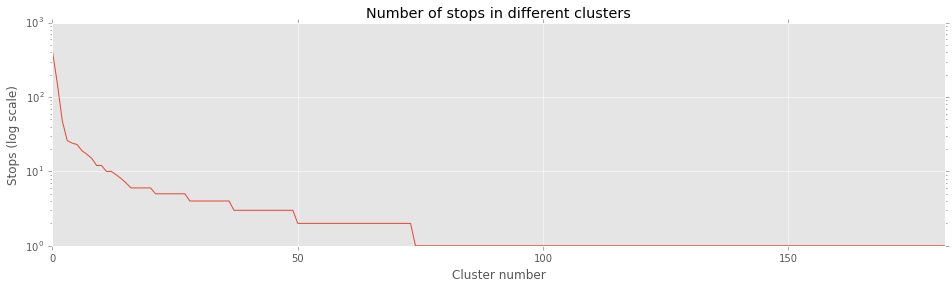

In [15]:
cluster_counts = stops['label'].value_counts()
cluster_labels = set(stops['label'])
print('We found %d stops where %.2f%% of the stops are from the first 2 clusters.' % \
      (cluster_counts.sum(), 
       cluster_counts[:2].sum()/float(cluster_counts.sum())*100))
print('Amount of places visited less than 5 times is %d out of %d.' % \
      (cluster_counts[cluster_counts<5].count(), cluster_counts.count()))

ax = cluster_counts.reset_index(drop=True).plot(figsize=(16,4), logy=True, title="Number of stops in different clusters");
ax.set_ylabel('Stops (log scale)'); ax.set_xlabel('Cluster number');

The duration of a stop varies from 15 minutes to hours so it is probably more correct to look at the time spent at each stop. Interestingly we see that outside the home and work, the time spent at different destinations are logarithmically declining. The amount of time at home or at work explains a larger amount of the total time compared to just the number of stops. This is, however, expected since the algorithm should create one long stop from when we arrive to when we leave. 

76.34% of the total time at stops are spent in the first 2 clusters.


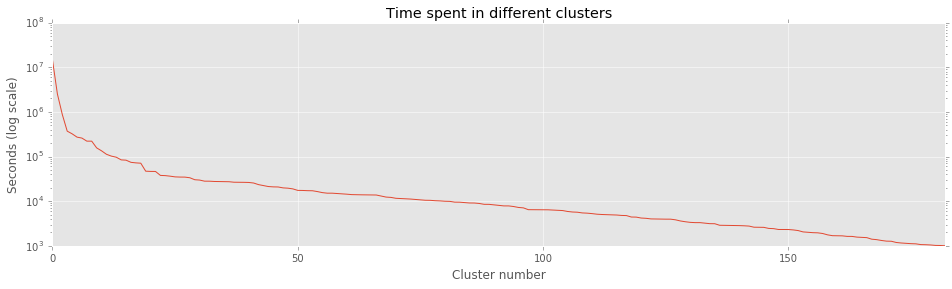

In [16]:
cluster_medians = stops[['label', 'lat', 'lon']].groupby('label').agg(np.median)
cluster_medians['time_spent'] = stops[['label', 'time_spent']].groupby('label').agg(np.sum)
cluster_medians = cluster_medians.sort_values(by='time_spent', ascending=False).reset_index()

ax = cluster_medians['time_spent'].plot(figsize=(16,4), logy=True, title="Time spent in different clusters");
ax.set_ylabel('Seconds (log scale)'); ax.set_xlabel('Cluster number');

print('%.2f%% of the total time at stops are spent in the first 2 clusters.' %
      (cluster_medians['time_spent'][:2].sum()/float(cluster_medians['time_spent'].sum())*100));

### Reverse Geocoding from location
With the location there are a number of services that can be used for reverse geocoding, to look up an address from a location. The best known geocoding services are probably OpenStreetMaps and Google which both are available through *geopy.geocoders*. In this case the address can be useful in determining what meaning a stop location has. Home, work, shopping etc.

In [17]:
geocoder = GoogleV3(api_key=api_key, domain="maps.google.dk")

def reverse_lookup(query):
    return geocoder.reverse(query, exactly_one=True, timeout=None, language=None, sensor=False)

In [18]:
cluster_names = []
for lat, lon in cluster_medians[['lat', 'lon']].itertuples(index=False):
    cluster_names.append(reverse_lookup((lat, lon)).address)
cluster_medians['address'] = cluster_names

In [19]:
cluster_medians[:5]

,label,lat,lon,time_spent,address
0,0,55.700413,12.552734,14445455.727,"Tagensvej 56, 2200 København N, Danmark"
1,8,55.783660,12.519412,2520189.006,"321, 2800 Kongens Lyngby, Danmark"
2,17,56.103577,10.210275,873363.845,"Moesgårdvej 15, 8270 Højbjerg, Danmark"
3,104,12.666322,99.939232,370342.368,"Unnamed Road, Tambon Cha-am, Amphoe Cha-am, Ch..."
4,3,55.693781,12.564407,322524.445,"Det Sundhedsvidenskabelige Fakultet, 2200 Købe..."


From the reverse lookup I can identify the first cluster as my home, the second and fifth as my working places, the third as my parents home and the fourth as a place of vacation this september. 

### Aggregate in days, weeks etc. over the full period
With all the stops identified we can look at summaries across different slices, e.g. weekdays and hours on the day. We know that about half of the time in the stops is contained in the first two clusters so I will limit the following to the top 5. 

In [20]:
top_labels = cluster_medians['label'][:5]

# Create containers with indexes at the resolution we want to look at
df_hour_of_day = pd.DataFrame(0, index=range(0, 24), columns=top_labels)
df_hour_of_day_wk = pd.DataFrame(0, index=range(0, 24), columns=top_labels)
df_day_of_week = pd.DataFrame(0, index=range(0, 7), columns=top_labels)
df_day_of_year = pd.DataFrame(0, index=range(0, 366), columns=top_labels)

# Iterate over all the stops that are in the top five clusters based on time spent
for i in stops[stops['label'].isin(top_labels)].itertuples():
    idx, user, lon, lat, arrival, departure, label, time_spent = i
    
    # Create a Pandas Series object with indices from arrival to departure at a frequency of one minute
    ts = pd.Series(0, index=pd.date_range(pd.to_datetime(arrival), pd.to_datetime(departure), freq='Min'))
    
    # Aggregate on different levels. We simply count the number of items in each group. Each item represents 1 minute
    ts_i = ts[ts.index.dayofweek<5]
    for ts_idx, ts_count in ts_i.groupby(ts_i.index.hour).count().iteritems():
        df_hour_of_day[label][ts_idx] += ts_count/60
    
    ts_i = ts[ts.index.dayofweek>4]
    for ts_idx, ts_count in ts_i.groupby(ts_i.index.hour).count().iteritems():
        df_hour_of_day_wk[label][ts_idx] += ts_count/60
        
    for ts_idx, ts_count in ts.groupby(ts.index.dayofweek).count().iteritems():
        df_day_of_week[label][ts_idx] += ts_count/60
        
    for ts_idx, ts_count in ts.groupby(ts.index.dayofyear).count().iteritems():
        df_day_of_year[label][ts_idx] += ts_count/60

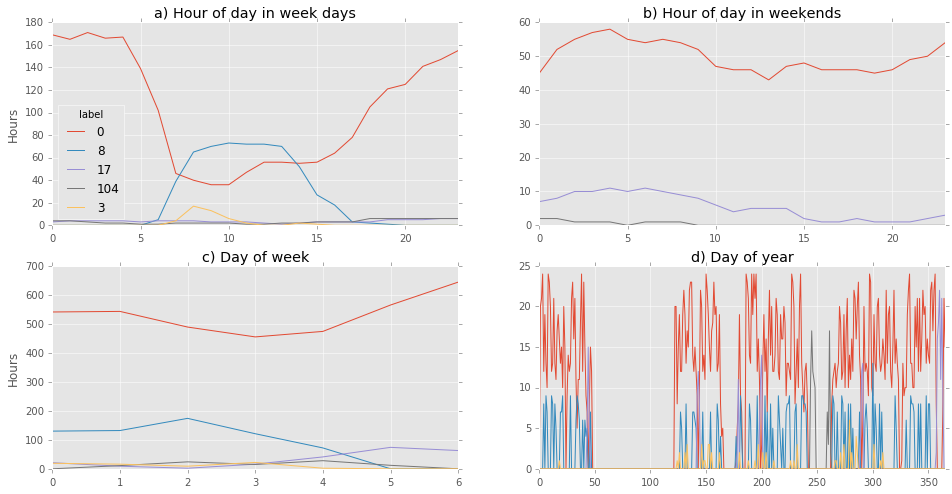

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df_hour_of_day.plot(title="a) Hour of day in week days", ax=axes[0, 0]);
df_hour_of_day_wk.plot(legend=False, title="b) Hour of day in weekends", ax=axes[0, 1]);
df_day_of_week.plot(legend=False, title="c) Day of week", ax=axes[1,0]);
df_day_of_year.plot(legend=False, title="d) Day of year", ax=axes[1,1]);
axes[0, 0].set_ylabel('Hours'), axes[1, 0].set_ylabel('Hours');

From the four different plots we can make some educated guesses about what these locations has of significance. From **a)** we can see that cluster 0 must be home since a lot of time is spent at night while cluster 8 must be work since many hours in the middle of the day is used here. The yellow line, cluster 3, is a bit odd but this is because I some times have meetings at KU in the morning after which I go home to work. From **b)** and **c)** we can further see that cluster 17 is a place almost only visited during weekends and is incidently my parents home i Aarhus. The last cluster is difficult to infer anything about from the first three plots but from **d)** we see that it emerges for a short period from which we can infer that it is a vacataion or external stay of a kind. In most cases it is probably save to infer home from the cluster which most time is spent during night and work as the cluster with most time spent at e.g. 10 am. 

In [22]:
label_home = np.argmax(df_hour_of_day.ix[0])
label_work = np.argmax(df_hour_of_day.drop(label_home, axis=1).ix[10])
print("Label for home: %d and work: %d" % (label_home, label_work))

Label for home: 0 and work: 8


### Analysing stops based on the distance
The clustering boundaries have a large effect on the size and resolution of stops so in order to examine whether we made a good choice for our analysis, one way is to visualize the distance between all clusters. To get a meaningful representation I ordered the stops with respect to the distance from the *home* cluster in ascending order.

In [23]:
# Find the distance from the home cluster
distance_from_home = np.empty(len(cluster_medians), dtype=np.float64)
for j in range(len(cluster_medians)):
    distance_from_home[j] = distance((cluster_medians['lat'][0], cluster_medians['lon'][0]),
                                     (cluster_medians['lat'][j], cluster_medians['lon'][j])).km
# Order by distance from home
cluster_medians_dist = cluster_medians.copy()
cluster_medians_dist['dist'] = distance_from_home
cluster_medians_dist = cluster_medians_dist.sort_values(by='dist').reset_index()

# Find all inter-cluster distances
num_clusters = len(cluster_medians_dist)
cluster_distance_matrix = np.zeros((num_clusters, num_clusters))
for i in xrange(num_clusters):
    for j in xrange(num_clusters):
        cluster_distance_matrix[i, j] = distance((cluster_medians_dist['lat'][i], cluster_medians_dist['lon'][i]),
                                                 (cluster_medians_dist['lat'][j], cluster_medians_dist['lon'][j])).km

Now I have generated a matrix of size *number of clusters x number of clusters* with increasing distance along the *x* and *y* direction. Because the distances vary a lot I will use a logarithmic scale when illustrating.

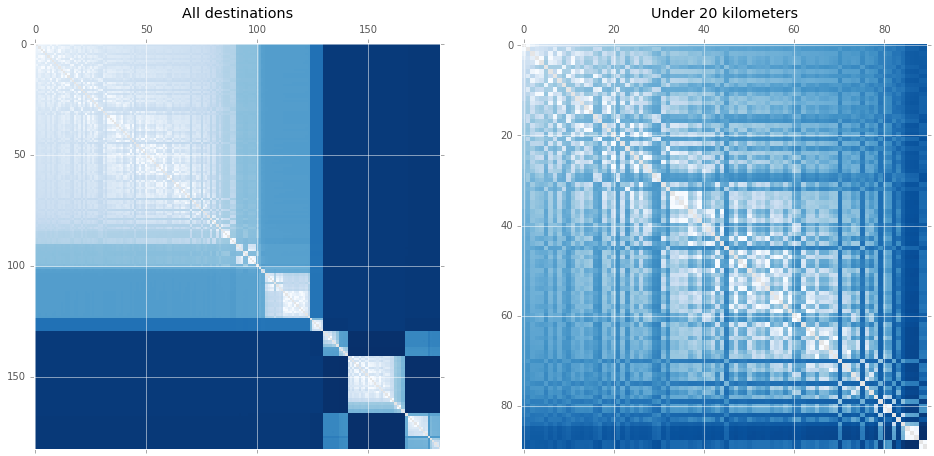

In [24]:
# Normalise the distances to be between 0 and 1
full_matrix = (cluster_distance_matrix - cluster_distance_matrix.min())/cluster_distance_matrix.max()

# Restrict to the first 90 which corresponds to about 20 km away from home and normalise
restricted_matrix = cluster_distance_matrix[:90, :90]
restricted_matrix = (restricted_matrix - restricted_matrix.min())/restricted_matrix.max()

fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
ax[0].matshow(full_matrix, cmap=plt.get_cmap('Blues'),
              norm=matplotlib.colors.LogNorm(vmin=full_matrix[0,1], vmax=1));
ax[0].set_title("All destinations");

ax[1].matshow(restricted_matrix, cmap=plt.get_cmap('Blues'),
              norm=matplotlib.colors.LogNorm(vmin=restricted_matrix[0,1], vmax=1));
ax[1].set_title("Under 20 kilometers");

From the distance matrices we see higher level groupings that could well indicate, Copenhagen, Lyngby, Sealand, Aarhus, USA etc. The smaller squares along the diagonal is the inter-community distances. So in Aarhus I tend to vist multiple locations that are close to each other relative to the distance from Copenhagen. A hierarchial clustering of stop locations would allow us to analyse stops within and across communities but I'm leaving that out for now. 

### Visualizing stops on maps
Using maps can be helpful in understanding both data and results from algorithms since they reflect the way we understand and think about the physical world. I am using Folium, a library that with ease takes a list of locations and plots them in Leaflet using maps from OpenStreetMap. On the map we get a visualization of all the stops but aggregated in clusters based on distance and zoom level. 

In [25]:
my_map = folium.Map(location=(55.7004128, 12.5527339), zoom_start=8, tiles='Stamen Toner')
MarkerCluster(cluster_medians[['lat', 'lon']].values, popups=cluster_medians['address']).add_to(my_map)
display(my_map);

## Paths
We define paths as the trajectories between stops with the assumptions that we are able to correctly identify stops and there is a sequence of points that connect two stops in a both spatial and temporal continuous order. 

### Speed
Time, distance and speed between points are useful for both inference about behaviour and detection of artifacts and errors in the data. Because the earth is not flat I use the [Haversine](https://en.wikipedia.org/wiki/Haversine_formula) distance measure between two points. 

In [26]:
def haversine(in_df):
    _df = in_df.copy()
    _df = _df[['lat', 'lon']].applymap(np.radians)
    df_diff = (_df - _df.shift(1))[1:]
    a = np.sin(df_diff['lat'].values / 2) ** 2 + \
        np.cos(_df['lat'].shift(1)[1:].values) * \
        np.cos(_df['lat'][:-1]).values * \
        np.sin(df_diff['lon'] / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367000 * c
    return m

In [27]:
df['distance'] = haversine(df)
df['time_diff'] = ((df['arrival'] - df['arrival'].shift(1))[1:] / 1e9)
df['speed'] = (df['distance'] / df['time_diff']) * 3.6
df = df.dropna()

For some reason there's often errors in the data where one datapoint is far away from the others. To detect and remove these I filter the speed with a simple edge detection filter and threshold at 150 which at this point is heuristically set. 

In [28]:
spike_filter = [-0.1, -0.1, -0.1, -0.1, -0.1, 1, -0.1, -0.1, -0.1, -0.1, -0.1]
spikes = np.convolve(spike_filter, df['speed'].values)[5:-5]
df = df[spikes < 150]

### Extracting paths
Extract every path between stops departure and arrival times. Save the _to_ and _from_ stop labels and give each trip a unique id. I also aggregate some info on each path so we don't have to calculate that every time we need it. 

In [29]:
path_info = []
paths = pd.DataFrame()
user, prev_lon, prev_lat, prev_arrival, prev_departure, prev_label, time_spent = stops.ix[0]
path_number = 0

for stop in stops[1:].itertuples(index=False):
    user, lon, lat, arrival, departure, label, time_spent = stop
    path = df.loc[pd.to_datetime(prev_departure):pd.to_datetime(arrival)].copy()
    
    path['from'] = prev_label
    path['to'] = label
    path['id'] = path_number
    paths = pd.concat((paths, path))
    
    path_info.append([distance((prev_lat, prev_lon), (lat, lon)).km, 
                      (arrival - prev_departure)/1e9,
                      path['to'].count()])
    
    # Save for next iteration
    prev_departure, prev_label, prev_lat, prev_lon = departure, label, lat, lon
    path_number += 1
                             
paths_info = pd.DataFrame(path_info, columns=['distance', 'duration', 'count'])

Many of the paths unfortunately consists of just few datapoints so we will trim those away for now. It would be interesting to interpolate paths by finding patterns in the behaviour from solely the *from* and *to* locations. If we have just one densely sampled trajectory on this path we can use that data in the rest. Alternatively we can pool all the data on this path and find the most probable and use that for the paths with few samples. 

In [30]:
# Only keep paths with more than 4 samples
paths = paths[paths['id'].isin(paths_info[paths_info['count'] > 4].index.values)]

This way we can find paths to and from work, independent on their start or end point. 

In [31]:
paths_to_work = paths[(paths['to']==label_work)]
paths_from_work = paths[(paths['from']==label_work)]
print("Number of paths to (%d) and from (%d) work" % (len(np.unique(paths_to_work['id'])),
      len(np.unique(paths_from_work['id']))))

Number of paths to (99) and from (99) work


The number of paths to and from work is the same but from the previous map I discovered that the clustering algorithm correctly identified 3 clusters at DTU and only one of these are identified as *work*. To identify the how correct the path labelling is we need to take a closer look at the paths and stop locations but that will have to wait for now. We can visualize the paths on a map to validate the correctness. Be there are a large number of paths I have scaled the opacity of each path with the number of location-points in the path. This way well represented and repeated paths stand out. 

In [32]:
paths_from_work_ids = np.unique(paths_from_work['id'])
paths_to_work_ids = np.unique(paths_to_work['id'])

# Create a map and add path
my_map = folium.Map(location=(55.7463042, 12.5477255), zoom_start=12, tiles='Stamen Toner')
for path_id in paths_to_work_ids:       
    opacity = np.min([paths_info['count'].loc[path_id]/500.0, 1])
    PolyLine(paths_to_work[['lat', 'lon']][paths_to_work['id'] == path_id].values, opacity=opacity).add_to(my_map)
    
for path_id in paths_from_work_ids:       
    opacity = np.min([paths_info['count'].loc[path_id]/500.0, 1])
    PolyLine(paths_from_work[['lat', 'lon']][paths_from_work['id'] == path_id].values, color='red', opacity=opacity).add_to(my_map)
    
display(my_map);

It is easy to identify the most used route to and from work and still possible to identify alternative routes. The *true* path is captured very well but there also exist a lot of sparsely sampled paths that provide much lower resolution. Further work in this would be to build a model over the all paths and when we analyse a path that contains a lot noise or just a few data points, we can get a better posterior estimate using the model. 

### Google Maps API

All the Google Maps API services can be accessed through the official Python library from Google, *googlemaps*. The services are documented at https://developers.google.com/maps/web-services/

In [33]:
gmaps = googlemaps.Client(key=api_key)

### Map-matching - Snap to roads
With a set of location points we can ask Google's service *Snap to roads* what is the most likely road these points follow. In case of noise this service is very nice, but it also requires you to make some assumptions about your data and Google's map quality. E.g. did the person generating the data actually follow a road known to Google? They also provide the option of interpolation so the returned path follows the road even when there's no original datapoint available. 

In [34]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def road_snap_to_array(path):
    return np.asarray([[d['location']['latitude'], d['location']['longitude']] for d in path])

def road_snap(df, interpolate=False):
    # Query limit of 100 points/request
    snaps = np.empty((0,2))
    for x in batch(df[['lat', 'lon']], 100):
        snaps = np.concatenate((snaps, road_snap_to_array(gmaps.snap_to_roads(x.values, interpolate=interpolate))), axis=0)
    return snaps

Lets extract a path from our list of paths and query that with interpolation on and off and visulize it on a map. The red is the raw path, the blue the *snapped to road* and the green is the interpolated path. 

In [35]:
# Define path to query
my_path = paths.loc[paths['id'] == np.unique(paths['id'])[0]]

# Get snaps for all points
snaps = road_snap(my_path, interpolate=False)
snaps_interp = road_snap(my_path, interpolate=True)

In [36]:
my_map = folium.Map(location=tuple(my_path[['lat', 'lon']].median().values), zoom_start=14, tiles='Stamen Toner')
PolyLine(my_path[['lat', 'lon']].values, color='red', opacity=0.8).add_to(my_map)
PolyLine(snaps, color='blue', opacity=0.8).add_to(my_map)
PolyLine(snaps_interp, color='green', opacity=0.8).add_to(my_map)
display(my_map)

The result is not very good in this case because the service makes some wrong assumptions about which roads to snap to even though the original datapoint is very close to the correct road. I suspect the density of datapoints are too low for the service to really work. Another reason could be that some of the roads where it went wrong are closed for cars and the service is aware of this. 

### Elevation
Google provides an API to get the elevation of a specific location. If you provide a path the resolution, or "inverse accuracy", is determined by how spatially close your location points are. The API can only handle about 50 points per request but it is also possible to specify a path by start and end location in which the service interpolates locations in a direct line along the path

In [37]:
def elevation_to_array(path):
    return np.asarray([[d['elevation'], d['resolution']] for d in path])

def get_elevation(df):
    elevation = np.empty((0,2))
    for x in batch(df[['lat', 'lon']], 50):
        elevation = np.concatenate((elevation, elevation_to_array(gmaps.elevation(x.values))), axis=0)
    return elevation

The API has a limit of 2500 free requests per day so in the testing phase we need to limit our queries. In this case we just use the path from above.

In [38]:
# Get elevation for all paths and add back to dataframe
elevation = get_elevation(my_path)
my_path['elevation'] = elevation[:, 0]
my_path['resolution'] = elevation[:, 1]

C:\Users\Simon\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Simon\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We can also get the elevation in a straight line between start and stop locations

In [39]:
start_point = my_path[['lat', 'lon']].ix[0].values
end_point = my_path[['lat', 'lon']].ix[-1].values
birdpath_elevation = elevation_to_array(gmaps.elevation_along_path(path=list((start_point, end_point)), samples=len(my_path)))

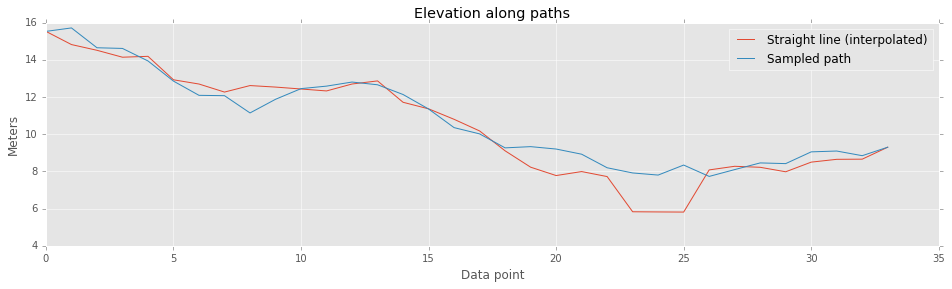

In [40]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(birdpath_elevation[:, 0], label='Straight line (interpolated)')
ax.plot(my_path[['elevation']].values, label='Sampled path');
ax.set_ylabel('Meters'), ax.set_xlabel('Data point'), ax.set_title('Elevation along paths')
plt.legend();

If you are familiar with the area the path goes through(north to south), the elevation curve fits well with what you would expect. The straigth line interpolation is very close to the true elevation but that follows from the path being very straigth in itself. Instead of interpolating the elevation from start to end it could be useful to interpolate between points along the path if they are far apart.

## Final remarks
Computational movement analysis is very powerful when quantifying human behaviour and as location data is practically free to sample from modern smartphones, the potential of research in this field is vast. As both Spek and Laube mentions, the analysis becomes much richer when aggregating data from additional sensors but many of these are also available in smartphones. In my project we also sample the accelerometer and the plan is to combine these with inferences from the movement analysis. The accelerometer provides high resolution information of small local changes in position but is not suited for inference of higher scale dynamics. Combining with location data we can make stronger inferences about what type of activity or situation people are in. As showed we can with relatively high certainty identify the domain (transport, home, work, leisure) people are in and using accelerometer data we hope to calculate a precise estimation of energy expenditure. The raw accelerometer data is a good measure in many cases but by having the speed and elevation when people are biking or walking in a hilly terrain, the estimation becomes much more accurate. Same goes for inference of the type of activity. 

The analysis up to this point has prepared the movement data for the combined modelling but it is not extensive and as comments along the way suggests there is various ways of improving and extending, including leveraging more advanced methods and other APIs. It has, however, shown how to acquire, pre-process and analyse movement data in different ways for different purposes using both simple visualisations and external services.

## References
Cuttone, Andrea, Sune Lehmann, and Jakob Eg Larsen. 2014. “Inferring Human Mobility from Sparse Low Accuracy Mobile Sensing Data.” Proceedings of the 2014 ACM International Joint Conference on Pervasive and Ubiquitous Computing Adjunct Publication - UbiComp ’14 Adjunct, 995–1004.

Laube, Patrick. 2015. “The Low Hanging Fruit Is Gone: Achievements and Challenges of Computational Movement Analysis.” SIGSPATIAL Special 7 (1). New York, NY, USA: ACM: 3–10.

Singh, Smita. 2015. “Spatial Temporal Analysis of Social Media Data.” Technische Universität München. [PDF](http://129.187.45.33/CartoMasterNew/fileadmin/user_upload/Smita_Report.pdf)

Stopczynski, Arkadiusz, Vedran Sekara, Piotr Sapiezynski, Andrea Cuttone, Mette My Madsen, Jakob Eg Larsen, and Sune Lehmann. 2014. “Measuring Large-Scale Social Networks with High Resolution.” PloS One 9 (4): e95978.

Van der Spek, Stefan, Jeroen Van Schaick, Peter De Bois, and Remco De Haan. 2009. “Sensing Human Activity: GPS Tracking.” Sensors  9 (4). Molecular Diversity Preservation International: 3033–55.